In [52]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

In [53]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [54]:
beta_gen = lambda d : np.array([1]*(d//2 + 1) + [0]*(d//2 - 1)) # 1. what does this do?
sigmoid = lambda x :  1/(1 + np.exp(-x))

In [55]:
def generate_spurious_data_anticausal(n, d, seed, rho=0): 
    # anticausal is a type of data generating process where p(y,z) changes 
    # across train and test while p( X | Y, Z) stays the same
    rng = np.random.RandomState(seed) 
    xs = rng.uniform(0.0, 1.0, size=(n * d)).reshape(n, d)
    noise = rng.normal(0.0, 0.5, size=n)
    beta = beta_gen(d)/np.sqrt(d)
  
    p_y_1_g_x = sigmoid(xs @ beta + rho) # p( y = 1 | X ) = sigma(beta^T x)

    ys = np.random.random(size=(n,)) < p_y_1_g_x # why does this sample from the bernoulli distirbution p( y = 1 | X )?

    p_z_1_g_x = sigmoid(rho*(2*ys - 1)) # p( z = 1 | X ) = sigma(beta_z^T x)
    
    zs = np.random.random(size=(n,)) < p_z_1_g_x # why does this work?

    xs[:, -1] = zs # This make model perfect as X and Y is perfect related

    # Z \not\perp Y \g X # this is wrong X--> Y --> Z, 
    
    # p(Y=y, Z=z| X) = 0 if  z\not= X[:, -1], do we agree? p(Y = y, Z=z, X=x) = 0 if z \not= x[:,-1], p(Y = y, Z=z, X=x) / p(X = x) = p(Y=y, Z=z| X)  = 0
    # p(Y=y| X) p(Z =z| X), p(Z =z| X)=0 when z\not= X[:, -1]
    # p(Y=y, Z=z| X) =  p(Y=y| X) p(Z =z| X) \implies Y \indep Z \g X

    # Y \not\indep Z \g X[:,0:d-1]

    return xs, ys, zs

In [68]:
n = 1000
d = 100
seed = 1
X,Y,Z = generate_spurious_data_anticausal(n, d, seed, rho=1)
X_test,Y_test,Z_test = generate_spurious_data_anticausal(n, d, seed, rho=1)

In [69]:
X = np.array(X)
Y = np.array(Y)
#X = np.reshape(X, (1000, 10))
print(X.shape)
print(Y.shape)
Y = np.ravel(Y)

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

(1000, 100)
(1000,)


In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 10*input_dim),
            nn.ReLU(),
            nn.Linear(10*input_dim, 10*input_dim),
            nn.ReLU(),
            nn.Linear(10*input_dim, output_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return torch.sigmoid(logits)

In [71]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [72]:
epochs = 1000
input_dim = 100 # Two inputs x1 and x2 
output_dim = 1 # Single binary output 
learning_rate = 0.01

In [73]:
model = NeuralNetwork(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [74]:
X = np.array(X)
Y = np.array(Y)
#X = np.reshape(X, (1000, 10))
Y = np.ravel(Y)

X = torch.from_numpy(X).to(torch.float32)
Y = torch.from_numpy(Y).to(torch.float32)

print(X.shape)

torch.Size([1000, 100])


In [75]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)
#X_test = np.reshape(X_test, (1000, 10))
Y_test = np.ravel(Y_test)

X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(Y_test).to(torch.float32)

In [76]:
losses = []
losses_test = []
Iterations = []
iter = 0

for epoch in range(int(epochs)):
    x = X
    labels = Y
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X)
    loss = criterion(torch.squeeze(outputs), labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%100==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, Y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += Y_test.size(0)
            correct_test += np.sum(predicted_test == Y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += Y.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == Y.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Iteration: 100. 
Test - Loss: 0.14428839087486267. Accuracy: 96.8
Train -  Loss: 0.14295288920402527. Accuracy: 96.8

Iteration: 200. 
Test - Loss: 0.14157027006149292. Accuracy: 96.8
Train -  Loss: 0.13972271978855133. Accuracy: 96.8

Iteration: 300. 
Test - Loss: 0.14139598608016968. Accuracy: 96.8
Train -  Loss: 0.13925598561763763. Accuracy: 96.8

Iteration: 400. 
Test - Loss: 0.14126087725162506. Accuracy: 96.8
Train -  Loss: 0.13884562253952026. Accuracy: 96.8

Iteration: 500. 
Test - Loss: 0.14112627506256104. Accuracy: 96.8
Train -  Loss: 0.13843564689159393. Accuracy: 96.8

Iteration: 600. 
Test - Loss: 0.140993133187294. Accuracy: 96.8
Train -  Loss: 0.1380249559879303. Accuracy: 96.8

Iteration: 700. 
Test - Loss: 0.14086034893989563. Accuracy: 96.8
Train -  Loss: 0.1376125067472458. Accuracy: 96.8

Iteration: 800. 
Test - Loss: 0.14072735607624054. Accuracy: 96.8
Train -  Loss: 0.13719883561134338. Accuracy: 96.8

Iteration: 900. 
Test - Loss: 0.1405949741601944. Accuracy: 

10
[0.14428839087486267, 0.14157027006149292, 0.14139598608016968, 0.14126087725162506, 0.14112627506256104, 0.140993133187294, 0.14086034893989563, 0.14072735607624054, 0.1405949741601944, 0.1404634714126587]


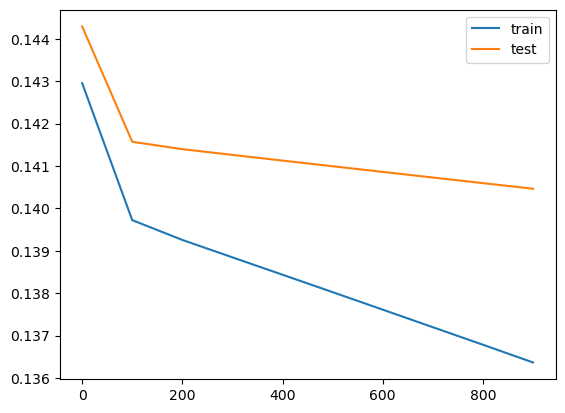

In [77]:
print(len(losses))
print(losses_test)
import matplotlib.pyplot as plt


epoches = [x for x in range(0,epochs,100)]
plt.plot(epoches, losses, label="train")
plt.plot(epoches, losses_test, label="test")
plt.legend()
plt.show()

In [66]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=1, bias=True)
  )
)


1. Tensors
2. Datasets and DataLoaders
3. Transforms
4. Build Model
5. Automatic Differentiation
6. Optimization Loop